In [200]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
import plotly.graph_objs as go

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve, precision_recall_curve, precision_score, recall_score,classification_report
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer


In [101]:
df = pd.read_csv('../Data/raw_df.csv')
df = df.drop_duplicates(keep='first').reset_index(drop=True)

DoS = list([
    'smurf', 'pod', 'neptune', 'teardrop', 'land', 'apache2', 
    'back', 'udpstorm', 'mailbomb', 'processtable'
])

U2R = list([

    'buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'xterm', 'ps', 
    'httptunnel', 'sqlattack', 'worm', 'snmpguess'
])

R2L = list([
    'guess_passwd', 'ftp_write', 'imap', 'phf', 'multihop', 'warezmaster',
    'snmpgetattack',  'named', 'xlock', 'xsnoop', 'sendmail'
])

Probe = list([
    'portsweep', 'ipsweep', 'nmap', 'saint', 'satan', 'mscan'
])

for attack in Probe:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'Probe')
    
for attack in DoS:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'DoS')

for attack in U2R:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'U2R')

for attack in R2L:
    df['deu_ruim_ou_nao']=df['deu_ruim_ou_nao'].str.replace(attack,'R2L')

In [102]:
df

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,deu_ruim_ou_nao
0,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
1,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,R2L
2,0,udp,private,SF,105,146,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,R2L
3,0,udp,private,SF,105,146,0,0,0,0,...,255,1.0,0.00,0.01,0.0,0.0,0.0,0.0,0.0,R2L
4,0,udp,domain_u,SF,29,0,0,0,0,0,...,3,0.3,0.30,0.30,0.0,0.0,0.0,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77286,0,icmp,ecr_i,SF,30,0,0,0,0,0,...,55,1.0,0.00,1.00,0.0,0.0,0.0,0.0,0.0,normal
77287,0,icmp,ecr_i,SF,30,0,0,0,0,0,...,56,1.0,0.00,1.00,0.0,0.0,0.0,0.0,0.0,normal
77288,0,udp,private,SF,105,105,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,R2L
77289,0,icmp,ecr_i,SF,30,0,0,0,0,0,...,67,1.0,0.00,1.00,0.0,0.0,0.0,0.0,0.0,normal


In [103]:
categorical_features = list(df.select_dtypes(include=['object']).columns)
numeric_features = list(df.select_dtypes(exclude=['object']).columns)

In [104]:
df_pp = df.copy()
for c in categorical_features:
    enc = LabelEncoder().fit(df_pp[c].values)
    enc_features = enc.transform(df_pp[c].values)
    df_pp[c] = enc_features

scaler = MinMaxScaler().fit(df_pp[numeric_features].values)
sc_features = scaler.transform(df_pp[numeric_features].values)
df_pp[numeric_features] = sc_features
    

In [105]:
X = df_pp.iloc[:,:-1]
y = df_pp.iloc[:,-1]

<h1> Mutual Info

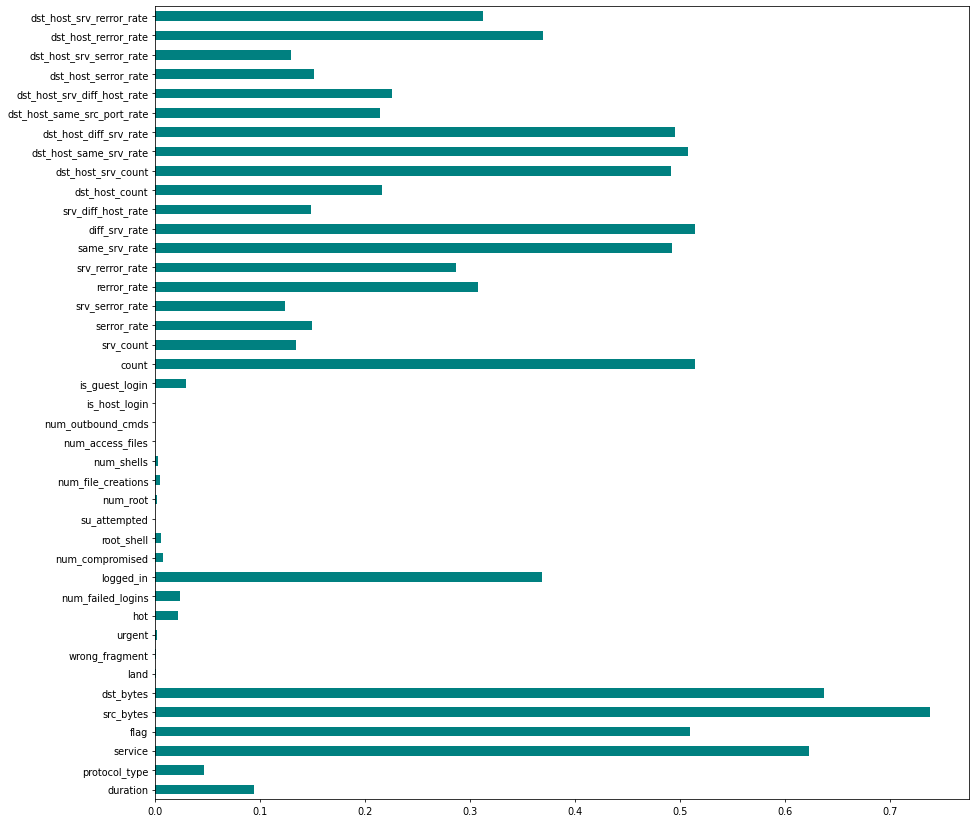

In [106]:
importances = mutual_info_classif(X,y)
feature_imp = pd.Series(importances, df_pp.columns[0:len(df_pp.columns)-1])
plt.figure(figsize=(15,15))
feature_imp.plot(kind = 'barh', color='teal')
plt.show()

In [107]:
MI_features = list(feature_imp.sort_values(ascending = False)[:20].index)

<h1> Correlation

<AxesSubplot:>

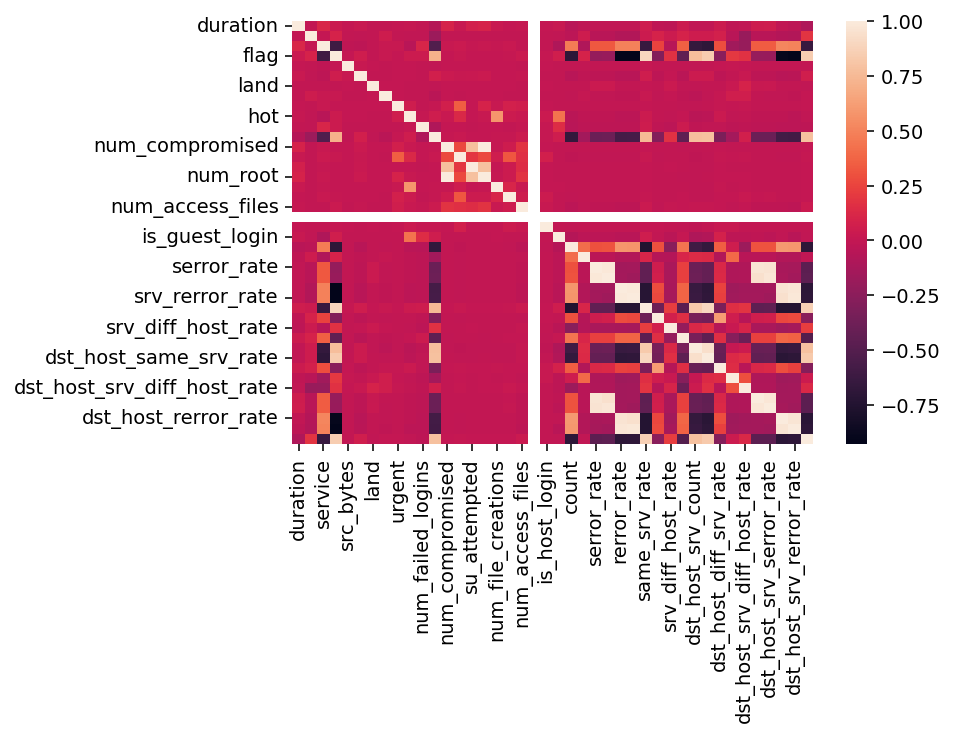

In [108]:
plt.rcParams['figure.dpi'] = 140
cor = df_pp.corr()
sns.heatmap(cor)

In [109]:
CORR_features = list(abs(cor['deu_ruim_ou_nao']).sort_values(ascending=False)[:21].index)
CORR_features.remove('deu_ruim_ou_nao')
len(CORR_features)

20

<h1> RF feature importance

In [110]:
rf = RandomForestClassifier(n_estimators=200)

rf.fit(X,y)
rffi = rf.feature_importances_

In [111]:
features = pd.Series(rffi, df_pp.columns[0:len(df_pp.columns)-1])
RFFI_features = list(features.sort_values(ascending = False)[:20].index)

In [112]:
len(RFFI_features)

20

<h1> SHAP

In [113]:
df_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77291 entries, 0 to 77290
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     77291 non-null  float64
 1   protocol_type                77291 non-null  int32  
 2   service                      77291 non-null  int32  
 3   flag                         77291 non-null  int32  
 4   src_bytes                    77291 non-null  float64
 5   dst_bytes                    77291 non-null  float64
 6   land                         77291 non-null  float64
 7   wrong_fragment               77291 non-null  float64
 8   urgent                       77291 non-null  float64
 9   hot                          77291 non-null  float64
 10  num_failed_logins            77291 non-null  float64
 11  logged_in                    77291 non-null  float64
 12  num_compromised              77291 non-null  float64
 13  root_shell      

In [114]:
X = df_pp.iloc[:,:-1]
y = df_pp.iloc[:,-1]

train_X, test_X, train_y, test_y = train_test_split(X,y, random_state=42)
rf = RandomForestClassifier(random_state=0).fit(train_X, train_y)

In [115]:
row = 1
row_instance = test_X.iloc[row]  # use 1 row of data here. Could use multiple rows if desired
row_pred = row_instance.values.reshape(1, -1)

rf.predict_proba(row_pred)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0., 1., 0., 0., 0.]])

In [116]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row_instance)

In [117]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], row_instance)

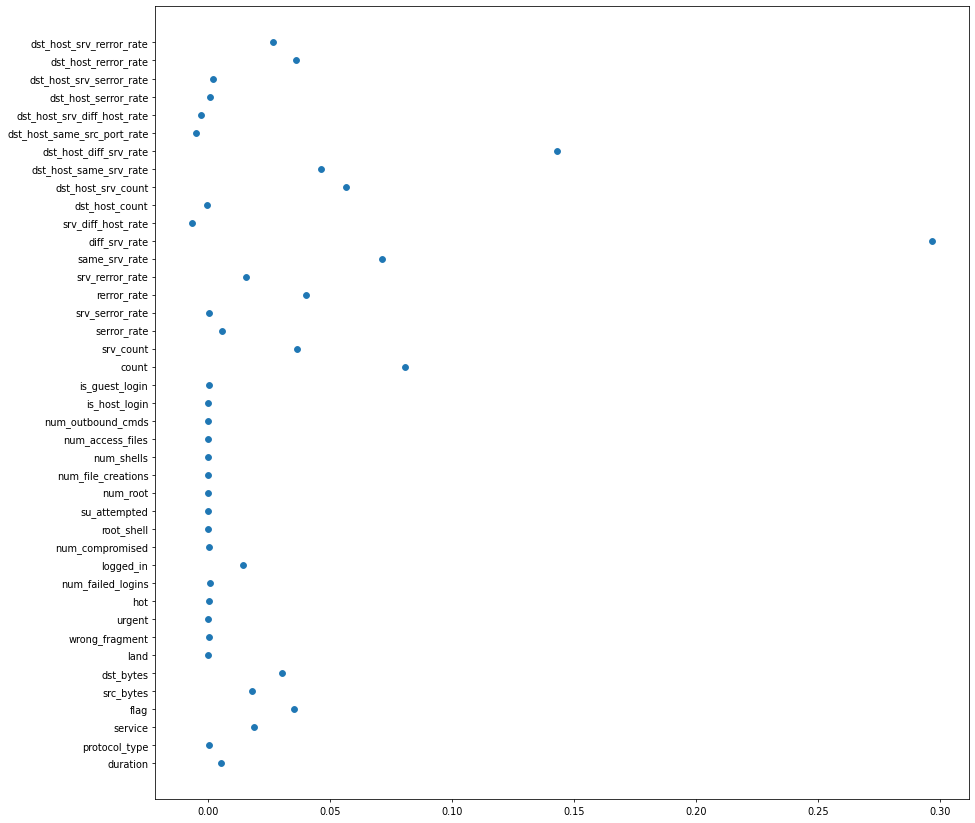

In [118]:
plt.rcParams['figure.dpi'] = 70

x = row_instance.index
y = shap_values[1]

plt.figure(figsize=(15,15))
plt.scatter(y,x)
plt.show()


In [119]:
shap_series_1 = pd.Series(y, x)
shap_features_1 = list(shap_series_1.sort_values(ascending = False)[:20].index)

In [120]:
shap_features_1

['diff_srv_rate',
 'dst_host_diff_srv_rate',
 'count',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'rerror_rate',
 'srv_count',
 'dst_host_rerror_rate',
 'flag',
 'dst_bytes',
 'dst_host_srv_rerror_rate',
 'service',
 'src_bytes',
 'srv_rerror_rate',
 'logged_in',
 'serror_rate',
 'duration',
 'dst_host_srv_serror_rate',
 'num_failed_logins']

In [121]:
row = 2
row_instance = test_X.iloc[row]  # use 1 row of data here. Could use multiple rows if desired
row_pred = row_instance.values.reshape(1, -1)

rf.predict_proba(row_pred)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[1., 0., 0., 0., 0.]])

In [122]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row_instance)

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], row_instance)

In [123]:
x = row_instance.index
y = shap_values[0]

shap_series_0 = pd.Series(y, x)
shap_features_0 = list(shap_series_0.sort_values(ascending = False)[:20].index)
shap_features_0

['flag',
 'dst_bytes',
 'same_srv_rate',
 'diff_srv_rate',
 'count',
 'logged_in',
 'dst_host_srv_serror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_count',
 'dst_host_diff_srv_rate',
 'serror_rate',
 'srv_serror_rate',
 'dst_host_same_src_port_rate',
 'service',
 'dst_host_srv_diff_host_rate',
 'src_bytes',
 'dst_host_count',
 'dst_host_same_srv_rate',
 'srv_diff_host_rate',
 'srv_count']

In [124]:
row = 4
row_instance = test_X.iloc[row]  # use 1 row of data here. Could use multiple rows if desired
row_pred = row_instance.values.reshape(1, -1)

rf.predict_proba(row_pred)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0., 0., 0., 0., 1.]])

In [125]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row_instance)

shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[4], row_instance)

In [126]:
x = row_instance.index
y = shap_values[4]

shap_series_4 = pd.Series(y, x)
shap_features_4 = list(shap_series_4.sort_values(ascending = False)[:20].index)
shap_features_4

['src_bytes',
 'dst_bytes',
 'flag',
 'same_srv_rate',
 'count',
 'protocol_type',
 'dst_host_srv_count',
 'dst_host_rerror_rate',
 'srv_count',
 'diff_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_srv_rerror_rate',
 'duration',
 'dst_host_same_srv_rate',
 'rerror_rate',
 'dst_host_same_src_port_rate',
 'num_failed_logins',
 'dst_host_srv_serror_rate',
 'dst_host_serror_rate',
 'srv_rerror_rate']

In [127]:
row = 9
row_instance = test_X.iloc[row]  # use 1 row of data here. Could use multiple rows if desired
row_pred = row_instance.values.reshape(1, -1)

rf.predict_proba(row_pred)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0., 0., 1., 0., 0.]])

In [128]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row_instance)

shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], row_instance)

In [129]:
x = row_instance.index
y = shap_values[2]

shap_series_2 = pd.Series(y, x)
shap_features_2 = list(shap_series_2.sort_values(ascending = False)[:20].index)
shap_features_2

['duration',
 'dst_bytes',
 'service',
 'src_bytes',
 'dst_host_rerror_rate',
 'srv_count',
 'count',
 'logged_in',
 'dst_host_diff_srv_rate',
 'flag',
 'same_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_src_port_rate',
 'protocol_type',
 'diff_srv_rate',
 'dst_host_srv_serror_rate',
 'dst_host_same_srv_rate',
 'dst_host_count',
 'dst_host_serror_rate',
 'srv_diff_host_rate']

In [167]:
row = 18852
row_instance = test_X.iloc[row]  # use 1 row of data here. Could use multiple rows if desired
row_pred = row_instance.values.reshape(1, -1)

rf.predict_proba(row_pred)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0., 0., 0., 1., 0.]])

In [168]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(row_instance)

shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3], row_instance)

In [170]:
x = row_instance.index
y = shap_values[3]

shap_series_3 = pd.Series(y, x)
shap_features_3 = list(shap_series_3.sort_values(ascending = False)[:20].index)
shap_features_3

['dst_bytes',
 'service',
 'src_bytes',
 'logged_in',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'protocol_type',
 'flag',
 'count',
 'dst_host_count',
 'dst_host_diff_srv_rate',
 'same_srv_rate',
 'srv_diff_host_rate',
 'dst_host_rerror_rate',
 'srv_count',
 'diff_srv_rate',
 'dst_host_srv_diff_host_rate',
 'duration',
 'dst_host_srv_serror_rate']

In [155]:
i = []
v = []
for index, value in zip(range(len(m)), m):    
    i.append(index)
    v.append(value)

t = pd.Series(v,i)
t[t==3]

In [185]:
shap_features = list(set(shap_features_0 + shap_features_1 + shap_features_2 + shap_features_3 + shap_features_4))

<h1> Model performance

In [ ]:
MI_features, CORR_features, RFFI_features, shap_features

In [211]:
def model_performance(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)

    plot_confusion_matrix(clf, X_test, y_test)
    plt.show()

    sk_report = classification_report(
    digits=6,
    y_true=y_test, 
    y_pred=y_pred)
    print(sk_report)

    performance_dictionary={'Class':[],'Accuracy':[],'F1_Score':[],'Precision':[],'Recall':[]}

    f1 = list(f1_score(y_test, y_pred, average=None))
    matrix = confusion_matrix(y_test, y_pred)
    acc = list(matrix.diagonal()/matrix.sum(axis=1))
    pr = list(precision_score(y_test, y_pred, average=None))
    rl = list(recall_score(y_test, y_pred, average=None))

    for i in range(len(f1)):

        performance_dictionary['Class'].append(i)
        performance_dictionary['Accuracy'].append(acc[i])
        performance_dictionary['F1_Score'].append(f1[i])
        performance_dictionary['Precision'].append(pr[i])
        performance_dictionary['Recall'].append(rl[i])

    df = pd.DataFrame.from_dict(performance_dictionary)

    return df

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


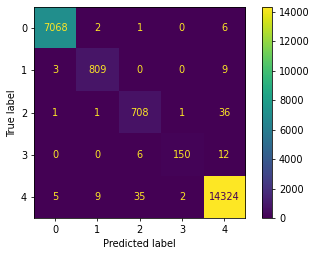

              precision    recall  f1-score   support

           0   0.998728  0.998728  0.998728      7077
           1   0.985384  0.985384  0.985384       821
           2   0.944000  0.947791  0.945892       747
           3   0.980392  0.892857  0.934579       168
           4   0.995621  0.996452  0.996036     14375

    accuracy                       0.994437     23188
   macro avg   0.980825  0.964242  0.972124     23188
weighted avg   0.994434  0.994437  0.994420     23188



,Class,Accuracy,F1_Score,Precision,Recall
0,0,0.998728,0.998728,0.998728,0.998728
1,1,0.985384,0.985384,0.985384,0.985384
2,2,0.947791,0.945892,0.944000,0.947791
3,3,0.892857,0.934579,0.980392,0.892857
4,4,0.996452,0.996036,0.995621,0.996452


In [213]:
X=df_pp[MI_features]
y=df_pp.iloc[:,-1]

MI_perf_df=model_performance(X,y)
MI_perf_df

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


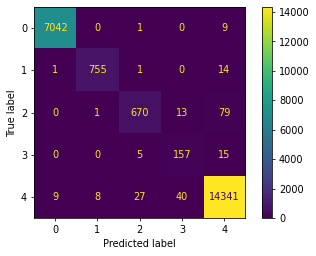

              precision    recall  f1-score   support

           0   0.998582  0.998582  0.998582      7052
           1   0.988220  0.979248  0.983713       771
           2   0.951705  0.878113  0.913429       763
           3   0.747619  0.887006  0.811370       177
           4   0.991908  0.994177  0.993041     14425

    accuracy                       0.990383     23188
   macro avg   0.935607  0.947425  0.940027     23188
weighted avg   0.990627  0.990383  0.990410     23188



,Class,Accuracy,F1_Score,Precision,Recall
0,0,0.998582,0.998582,0.998582,0.998582
1,1,0.979248,0.983713,0.988220,0.979248
2,2,0.878113,0.913429,0.951705,0.878113
3,3,0.887006,0.811370,0.747619,0.887006
4,4,0.994177,0.993041,0.991908,0.994177


In [214]:
X=df_pp[CORR_features]
y=df_pp.iloc[:,-1]

CORR_perf_df=model_performance(X,y)
CORR_perf_df

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


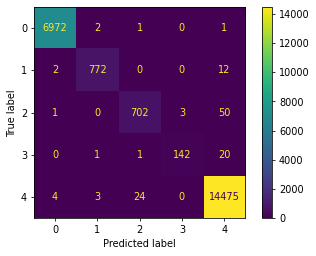

              precision    recall  f1-score   support

           0   0.998997  0.999427  0.999212      6976
           1   0.992288  0.982188  0.987212       786
           2   0.964286  0.928571  0.946092       756
           3   0.979310  0.865854  0.919094       164
           4   0.994299  0.997863  0.996078     14506

    accuracy                       0.994609     23188
   macro avg   0.985836  0.954781  0.969537     23188
weighted avg   0.994559  0.994609  0.994546     23188



,Class,Accuracy,F1_Score,Precision,Recall
0,0,0.999427,0.999212,0.998997,0.999427
1,1,0.982188,0.987212,0.992288,0.982188
2,2,0.928571,0.946092,0.964286,0.928571
3,3,0.865854,0.919094,0.979310,0.865854
4,4,0.997863,0.996078,0.994299,0.997863


In [215]:
X=df_pp[RFFI_features]
y=df_pp.iloc[:,-1]

RFFI_perf_df=model_performance(X,y)
RFFI_perf_df

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


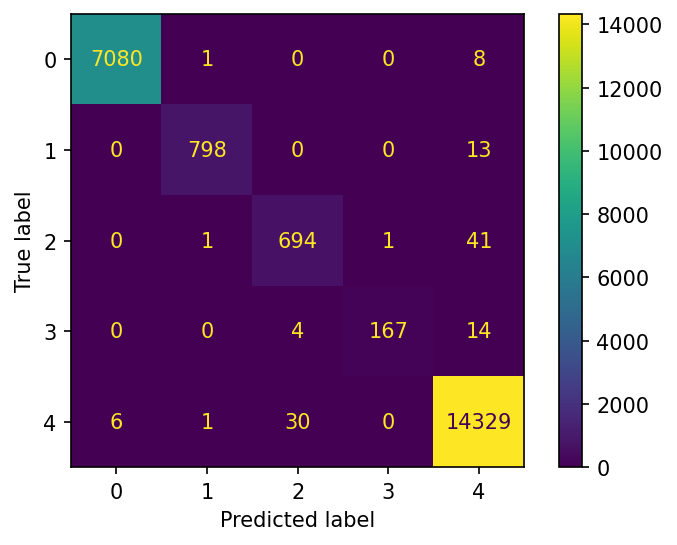

              precision    recall  f1-score   support

           0   0.999153  0.998730  0.998942      7089
           1   0.996255  0.983970  0.990074       811
           2   0.953297  0.941655  0.947440       737
           3   0.994048  0.902703  0.946176       185
           4   0.994724  0.997424  0.996072     14366

    accuracy                       0.994825     23188
   macro avg   0.987495  0.964897  0.975741     23188
weighted avg   0.994810  0.994825  0.994796     23188



,Class,Accuracy,F1_Score,Precision,Recall
0,0,0.998730,0.998942,0.999153,0.998730
1,1,0.983970,0.990074,0.996255,0.983970
2,2,0.941655,0.947440,0.953297,0.941655
3,3,0.902703,0.946176,0.994048,0.902703
4,4,0.997424,0.996072,0.994724,0.997424


In [232]:
X=df_pp[shap_features]
y=df_pp.iloc[:,-1]

SHAP_perf_df=model_performance(X,y)
SHAP_perf_df

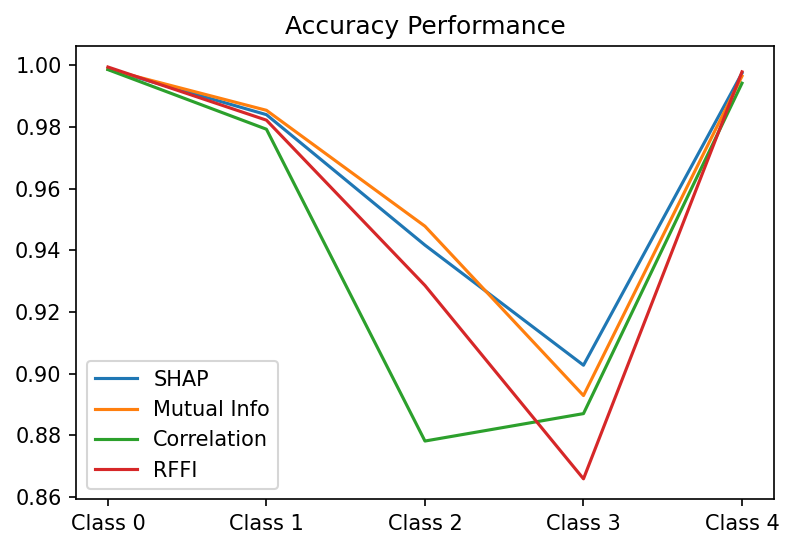

In [233]:
plt.rcParams['figure.dpi'] = 150
x = ['Class 0','Class 1','Class 2','Class 3','Class 4']
shap_acc = list(SHAP_perf_df['Accuracy'])
MI_acc = list(MI_perf_df['Accuracy'])
CORR_acc = list(CORR_perf_df['Accuracy'])
RFFI_acc = list(RFFI_perf_df['Accuracy'])

plt.plot(x, shap_acc, label = "SHAP")
plt.plot(x, MI_acc, label = "Mutual Info")
plt.plot(x, CORR_acc, label = "Correlation")
plt.plot(x, RFFI_acc, label = "RFFI")

plt.title('Accuracy Performance')
plt.legend()
plt.show()

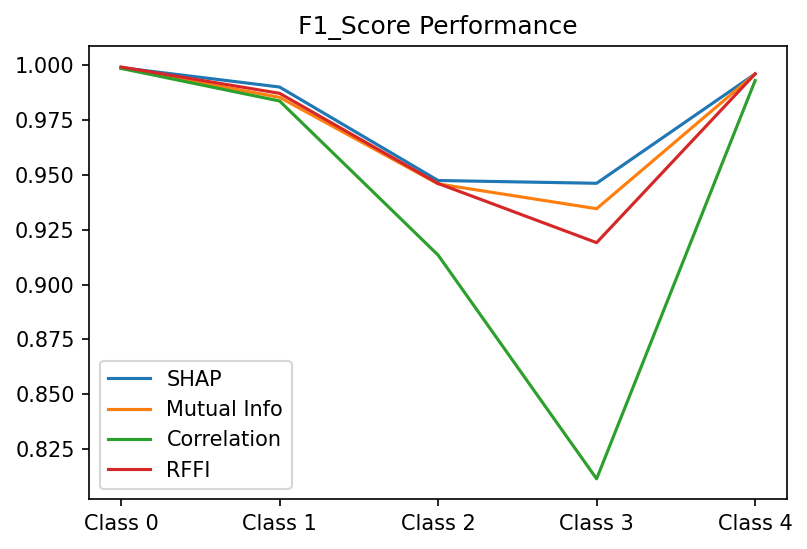

In [234]:
plt.rcParams['figure.dpi'] = 150
offset = 10

x = ['Class 0','Class 1','Class 2','Class 3','Class 4']
shap_acc = list(SHAP_perf_df['F1_Score'])
MI_acc = list(MI_perf_df['F1_Score'])
CORR_acc = list(CORR_perf_df['F1_Score'])
RFFI_acc = list(RFFI_perf_df['F1_Score'])

plt.plot(x, shap_acc, label = "SHAP")
plt.plot(x, MI_acc, label = "Mutual Info")


plt.plot(x, CORR_acc, label = "Correlation")

plt.plot(x, RFFI_acc, label = "RFFI")


plt.title('F1_Score Performance')
plt.legend()
plt.show()

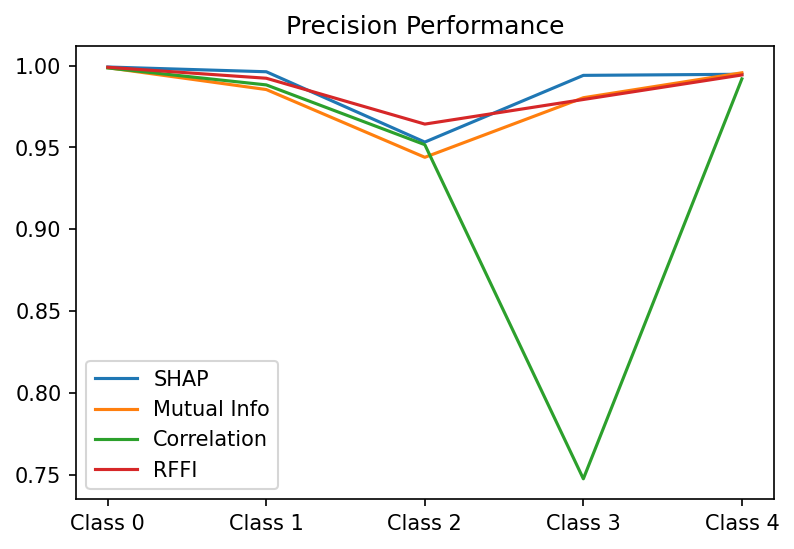

In [235]:
plt.rcParams['figure.dpi'] = 150
x = ['Class 0','Class 1','Class 2','Class 3','Class 4']
shap_acc = list(SHAP_perf_df['Precision'])
MI_acc = list(MI_perf_df['Precision'])
CORR_acc = list(CORR_perf_df['Precision'])
RFFI_acc = list(RFFI_perf_df['Precision'])

plt.plot(x, shap_acc, label = "SHAP")
plt.plot(x, MI_acc, label = "Mutual Info")
plt.plot(x, CORR_acc, label = "Correlation")
plt.plot(x, RFFI_acc, label = "RFFI")

plt.title('Precision Performance')
plt.legend()
plt.show()

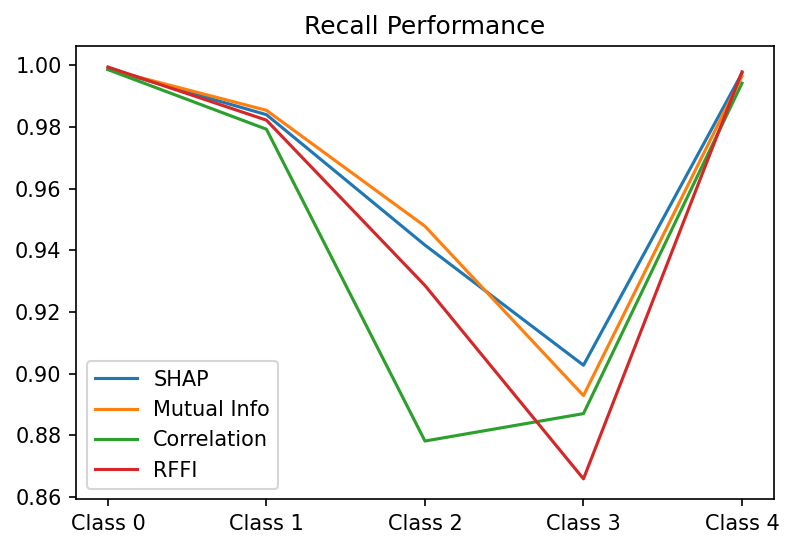

In [236]:
plt.rcParams['figure.dpi'] = 150
x = ['Class 0','Class 1','Class 2','Class 3','Class 4']
shap_acc = list(SHAP_perf_df['Recall'])
MI_acc = list(MI_perf_df['Recall'])
CORR_acc = list(CORR_perf_df['Recall'])
RFFI_acc = list(RFFI_perf_df['Recall'])

plt.plot(x, shap_acc, label = "SHAP")
plt.plot(x, MI_acc, label = "Mutual Info")
plt.plot(x, CORR_acc, label = "Correlation")
plt.plot(x, RFFI_acc, label = "RFFI")

plt.title('Recall Performance')
plt.legend()
plt.show()

In [237]:
SHAP_perf_df

,Class,Accuracy,F1_Score,Precision,Recall
0,0,0.998730,0.998942,0.999153,0.998730
1,1,0.983970,0.990074,0.996255,0.983970
2,2,0.941655,0.947440,0.953297,0.941655
3,3,0.902703,0.946176,0.994048,0.902703
4,4,0.997424,0.996072,0.994724,0.997424
